In [1]:
import pandas as pd
import numpy as np
import random
import math
from numpy import random
import cmath
import matplotlib.pyplot as plt

In [2]:
# Load datasets related to Base Stations, UAVs, and Clients
base = pd.read_csv(r'BS_data.csv')
uav = pd.read_csv(r'UAV_data.csv')
people = pd.read_csv(r'people_data.csv')
IRS=pd.read_csv(r'IRS_data.csv')
p_km_UP=pd.read_csv(r'P_km_up.csv')

Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename
f_km1=pd.read_csv(r'f_km.csv')

In [5]:
# Constants
Wl = 35.28
H_value= 20
P_m_har = base['P_m_har']
T_m_har = base['T_m_har']
P_m_down = base['P_m_down']
f_km=f_km1['0']
V_lm_vfly = uav['V_lm_vfly']
V_lm_hfly = uav['V_lm_hfly']
D_l_hfly = 100

P_km_up=p_km_UP['0']
p_max=10 # moved inside loop
p_km_max=10
T_m=10
D_m_current=0.49


# Additional constants for calculations
delta = 2
Ar = 0.1256
s = 0.05
Nr = 4
V_tip = 102
Cd = 0.022
Af = 0.2113
D_km = 0.5
# Dm=0.49
B=10 #MHz
sigma_km=10**(-13)
eta=10
kappa=0.5
num_population=50
Bh = (1 - 2.2558 * pow(10, -5) *H_value)**4.2577
# Bh = max(1, Bh)
p_l_b = (delta / 8) * Bh * Ar * s * pow(V_tip, 3)

In [6]:
# Determine the maximum possible rows based on the smallest dataframe size
min_rows = min(len(Angle_df), len(h_l_km_df), len(h_l_m_df), len(Angle_UP_df), len(g_l_km_df), len(g_l_m_df), len(Angle_har_df), len(f_l_km_df), len(f_l_m_df), len(f_km1))
num_rows_data_files = min_rows # Dynamically set num_rows_data_files based on the smallest dataframe length
population_size = min(50, num_rows_data_files) # Ensure population_size is not larger than available data

In [8]:
# Fitness function to calculate total energy consumption
def Fitness(E_ml_har, E_ml_down, E_ml_UAV):
    return E_ml_har + E_ml_down + E_ml_UAV

# Energy consumption of the UAV-IRS
def E_ml_UAV(P_l_vfly, T_l_vfly, P_lm_hfly, T_l_hfly, P_l_hov, T_lm_hov):
    return P_l_vfly * T_l_vfly + P_lm_hfly * T_l_hfly + P_l_hov * T_lm_hov

# Power calculations for different flight modes
def P_l_vfly(Wl, V_l_vfly, P_l_b, Nr, Ar, Bh):
    temp2 = Nr * Bh * Ar
    temp3 = np.sqrt(V_l_vfly**2 + (2 * Wl) / temp2)
    return ((Wl / 2) * (V_l_vfly + temp3)) + Nr * P_l_b

def P_lm_hfly(P_lm_blade, P_lm_fuselage, P_lm_induced):
    return P_lm_blade + P_lm_fuselage + P_lm_induced

def P_lm_blade(Nr, P_l_b, V_tip, V_lm_hfly):
    return Nr * P_l_b * (1 + ((3 * (V_lm_hfly**2)) / pow(V_tip, 2)))

def P_lm_fuselage(Cd, Af, Bh, V_lm_hfly):
    return (1 / 2) * Cd * Af * Bh * (V_lm_hfly**3)

def P_lm_induced(Nr, Bh, Ar, Wl, V_lm_hfly):
    return Wl * ((np.sqrt((Wl**2) / (4 * (Nr**2) * (Bh**2) * (Ar**2)) + ((V_lm_hfly**4) / 4)) - ((V_lm_hfly**2) / 2))**(1 / 2))

def P_l_hov(Wl, P_l_b, Nr, Ar, Bh):
    temp1 = Nr * P_l_b
    temp3 = np.sqrt(2 * (Nr * Bh * Ar))
    temp4 = ((Wl)**3 / 2) / temp3
    return temp1 + temp4

def T_lm_hov(T_km_com, T_kml_up, T_ml_down):
    return T_km_com + T_kml_up + T_ml_down

def R_ml_down(B,P_m_down,h_ml_worst): #eqation number 7
    temp1=(h_ml_worst*P_m_down) # Consider if min is the correct aggregation. It should be multiplication
    if (1+temp1) <= 0:
        return 0  # Return 0 if log argument is non-positive to avoid error
    return B*math.log2(1+temp1)

def h_ml_worst(h_kml_down,sigma_km): #eqation number 8
    return h_kml_down/(sigma_km) # it will return the sigal value which is minimum of all
            # the value for each itaration

def calculate_exp_i_theta(theta): # part of equation 8
  return cmath.exp(1j * theta)
 # 1j represents the imaginary unit in Python

def h_kml_down(Angle,h_l_m,h_l_km, num_irs_ele): # Modified: Added num_irs_ele argument
    result=[]
    if isinstance(Angle, float):
        return 0

    if not isinstance(Angle, pd.Series):
        raise TypeError(f"Expected Angle to be pd.Series, got {type(Angle)}")

    # Slice Series to num_irs_ele inside the function
    Angle_sliced = Angle.iloc[:num_irs_ele]
    h_l_m_sliced = h_l_m.iloc[:num_irs_ele]
    h_l_km_sliced = h_l_km.iloc[:num_irs_ele]

    for i in range(len(Angle_sliced)): # Iterate over the sliced Angle
        theta_radians = math.radians(Angle_sliced.iloc[i])
        results= calculate_exp_i_theta(theta_radians)
        result.append(results)

    diagonal=np.diag(result)
    h_l_m_np = h_l_m_sliced.to_numpy() # Convert sliced Series to numpy array
    h_l_km_np = h_l_km_sliced.to_numpy() # Convert sliced Series to numpy array
    if h_l_m_np.ndim == 1:
        h_l_m_np = h_l_m_np.reshape(1, -1)
    if h_l_km_np.ndim == 1:
        h_l_km_np = h_l_km_np.reshape(-1, 1)


    a=np.dot(h_l_m_np,diagonal)
    b=np.dot(a,h_l_km_np)
    final=abs(b[0][0])
    return (final**2)

def R_kml_up(B,P_km_up,h_kml_up,Sub,sigma_m): #eqation number 4
    temp1=(P_km_up*h_kml_up)/ (Sub+(sigma_m))
    return B*math.log2(1+temp1)
#this is inside the equation 4 have to take summation of h_i_up and P_i_up
def sub(P_i_up,h_il_up):
    return P_i_up*h_il_up

def E_km_com(f_km,T_km_com):
    return eta*(10**(-28))*(f_km**3)*T_km_com

def E_kml_up(P_km_up,T_km_up):
    return P_km_up*T_km_up

def E_kml_har(P_m_har,T_m_har,h_km_har):
    return kappa*P_m_har*T_m_har*h_km_har

In [9]:
num_population=50
num_bs = 5
num_generation = 1
num_uav_irs = 8
population_size = 50

numerical_keys_for_crossover = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','f_km_value',
]

fitness_sums_GA = [] # Store sum of fitness values for each num_irs_ele
irs_element_values = range(10, 51, 5) # num_irs_ele values from 10 to 50 in steps of 5


for num_irs_ele in irs_element_values: # Loop through different num_irs_ele values
    print(f"Calculation for num_irs_ele: {num_irs_ele}")

    Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
    h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
    h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

    Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
    g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
    g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

    Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
    f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
    f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename


    all_best_combinations = []
    all_best_individuals = []

    for l in range(num_bs):
        all_best_individuals_bs = []
        P_m_har_value = P_m_har.values[l]
        T_m_har_value = T_m_har.values[l]
        P_m_down_value = P_m_down.values[l]


        index_list = list(range(500))
        random.shuffle(index_list)
        unique_row_indices = index_list[:population_size]

        h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
        valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
        P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


        for k in range(num_uav_irs):
            best_fitness = float('inf')
            best_individual = {}
            population = []
            V_lm_vfly_value = V_lm_vfly.values[k]
            V_lm_hfly_value = V_lm_hfly.values[k]
            D_l_hfly_value = D_l_hfly
            Wl_value = Wl
            Sub_value=0

            for i in range(len(valid_indices)):
                # Slice the Angle_UP_df, g_l_m_df, g_l_km_df_bs to num_irs_ele columns
                Angle_UP_df_sliced = Angle_UP_df.iloc[i, :num_irs_ele]
                g_l_m_df_sliced = g_l_m_df.iloc[k, :num_irs_ele]
                g_l_km_df_bs_sliced = g_l_km_df_bs.iloc[i, :num_irs_ele]

                h_il_up_value=h_kml_down(Angle_UP_df_sliced, g_l_m_df_sliced, g_l_km_df_bs_sliced, num_irs_ele) # Pass num_irs_ele
                Sub_value+=sub(P_km_up_bs[i],h_il_up_value)


            for i in range(population_size):
                f_km_value = f_km_bs[i]
                P_km_up_value = P_km_up_bs[i]

                # Slice the Angle_df, h_l_m_df, h_l_km_df_bs, Angle_har_df, f_l_m_df, f_l_km_df_bs to num_irs_ele columns
                Angle_row = Angle_df.iloc[i, :num_irs_ele]
                h_l_m_row = h_l_m_df.iloc[k, :num_irs_ele]
                h_l_km_row = h_l_km_df_bs.iloc[i, :num_irs_ele]
                Angle1_row = Angle_UP_df.iloc[i, :num_irs_ele] # using sliced version not needed again
                g_l_m_row = g_l_m_df.iloc[k, :num_irs_ele]  # using sliced version not needed again
                g_l_km_row = g_l_km_df_bs.iloc[i, :num_irs_ele] # using sliced version not needed again
                Angle2_row = Angle_har_df.iloc[i, :num_irs_ele]
                f_l_m_row = f_l_m_df.iloc[k, :num_irs_ele]
                f_l_km_row = f_l_km_df_bs.iloc[i, :num_irs_ele]


                P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                T_l_vfly_value = H_value / V_lm_vfly_value
                T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value
                E_ml_har_value = P_m_har_value * T_m_har_value
                h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row, num_irs_ele) # Pass num_irs_ele
                h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
                R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                T_ml_down_value=D_m_current/R_ml_down_value # using global Dm
                E_ml_down_value = P_m_down_value * T_ml_down_value
                T_km_com_value = D_km / f_km_value
                h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row, num_irs_ele) # Pass num_irs_ele

                R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
                T_km_up_value=D_m_current/R_kml_up_value # using global Dm
                T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

                result_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

                population.append({
                    'fitness': result_fitness,
                    'data':  {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'T_km_up_value': T_km_up_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row,
                        }
                    })

            generations_data = []
            for j in range(num_generation):
                child_population = []
                                    # Corrected loop range to use valid_indices length
                for i in range(0, len(valid_indices), 2): # Loop through population with step of 2
                    if i + 1 >= len(valid_indices): # Check if i+1 is within bounds, if not break to avoid error in accessing population[i+1]
                        break
                    ranodmpopulation=[]
                    for i in range(10):
                        ranodmpopulation.append(random.choice(population))
                    ranodmpopulation = sorted(ranodmpopulation, key=lambda x: x['fitness'])
                    parent1 = ranodmpopulation[0]
                    parent2 = ranodmpopulation[1]
                    child_data = {}
                    for key in parent1['data']:

                        if key in numerical_keys_for_crossover: # Apply crossover only to numerical keys
                            if isinstance(parent1['data'][key], (pd.Series, np.ndarray)): # Check for both Series and NumPy array
                                child_data[key] = float(parent1['data'][key].iloc[0]) * 0.6 + float(parent2['data'][key].iloc[0]) * (1 - 0.6)
                            else:
                                child_data[key] = float(parent1['data'][key]) * 0.6 + float(parent2['data'][key]) * (1 - 0.6)
                        else:
                            # For non-numerical keys (like index lists, angle rows), simply copy from parent1
                            child_data[key] = parent1['data'][key]


                    # Mutation
                    u = np.random.uniform(0, 1, 1)[0]
                    P_mutation = 0.5
                    if u < P_mutation:
                        for key in numerical_keys_for_crossover: # Apply mutation only to numerical keys
                            child_data[key] += random.normal(loc=0, scale=1, size=(1))[0]


                def compute_fitness(data):
                    P_m_down_value = data['P_m_down_value']
                    P_m_har_value = data['P_m_har_value']
                    T_m_har_value = data['T_m_har_value']
                    f_km_value = data['f_km_value']
                    T_km_up_value = data['T_km_up_value']
                    V_lm_vfly_value = data['V_lm_vfly_value']
                    V_lm_hfly_value = data['V_lm_hfly_value']
                    P_km_up_value=data['P_km_up_value']
                    Angle_row = data['Angle_row']
                    Angle1_row = data['Angle1_row']
                    Angle2_row = data['Angle2_row']




                    P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                    P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                    P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                    T_l_vfly_value = H_value / V_lm_vfly_value
                    T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value
                    E_ml_har_value = P_m_har_value * T_m_har_value

                    h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row, num_irs_ele) # Pass num_irs_ele
                    h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                    R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                    if R_ml_down_value <= 0:
                        R_ml_down_value = 1e-9
                    T_ml_down_value=D_m_current/R_ml_down_value # using global Dm
                    E_ml_down_value = P_m_down_value * T_ml_down_value
                    T_km_com_value = D_km / f_km_value
                    T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                    P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                    P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                    P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                    E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                    h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row, num_irs_ele) # Pass num_irs_ele
                    E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected: removed h_kml_har
                    E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                    E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)

                    fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                    current_data = {
                            'P_m_down_value': P_m_down_value,
                            'P_m_har_value': P_m_har_value,
                            'T_m_har_value': T_m_har_value,
                            'f_km_value': f_km_value,
                            'T_km_up_value': T_km_up_value,
                            'V_lm_vfly_value': V_lm_vfly_value,
                            'V_lm_hfly_value': V_lm_hfly_value,
                            'P_km_up_value':P_km_up_value,
                            'Angle1_row':Angle1_row,
                            'Angle_row':Angle_row,
                            'Angle2_row': Angle2_row,
                                                }
                    if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                        return fitness_value, current_data
                    else:
                        return  float('inf'),{}

                child_fitness, child_data1 = compute_fitness(child_data)
                child_population.append({'fitness': child_fitness, 'data': child_data1})
            # Create new population
                new_population = population + child_population
                new_population = sorted(new_population, key=lambda x: x['fitness'])
                population = new_population[:population_size]
                generations_data.append(population[0].copy())
                # print(population[0])

            best_individual_pair = population[0].copy()
            best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
            best_individual_pair['type'] = 'GA'
            best_individual_pair['bs_index'] = l
            best_individual_pair['uav_index'] = k
            all_best_individuals_bs.append(best_individual_pair)

            all_best_combinations.append({
                'bs_index': l,
                'uav_index': k,
                'best_fitness': population[0]['fitness'],
                'best_individual': best_individual_pair,
                'generation_fitness': [gen['fitness'] for gen in generations_data],
                'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
            })
            # print(f"Best Fitness for BS {l}, UAV {k}: {population[0]['fitness']:.4f}")

        # Find best individual for current BS across all UAVs
        best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
        # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


    # Select the best unique Base station and UAV-IRS pair using Auction based method
    combination_lookup = {}
    for combination in all_best_combinations:
        if combination['bs_index'] not in combination_lookup:
            combination_lookup[combination['bs_index']] = {}
        combination_lookup[combination['bs_index']][combination['uav_index']] = combination

    # Auction-based assignment
    best_assignments = []
    unassigned_bs = list(range(num_bs))
    unassigned_uavs = list(range(num_uav_irs))

    while unassigned_bs and unassigned_uavs:
        best_combination_overall = None

        for l in unassigned_bs:
            best_fitness_for_bs = float('inf')
            best_combination_for_bs = None
            for k in unassigned_uavs:
                if l in combination_lookup and k in combination_lookup[l]:
                    combination = combination_lookup[l][k]
                    if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                        best_fitness_for_bs = combination['best_fitness']
                        best_combination_for_bs = combination

            if best_combination_for_bs:
                if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                    best_combination_overall = best_combination_for_bs

        if best_combination_overall:
            best_assignments.append(best_combination_overall)
            unassigned_bs.remove(best_combination_overall['bs_index'])
            unassigned_uavs.remove(best_combination_overall['uav_index'])

    # Print and Plotting
    print(f"\n--- Best Unique UAV Assignments (Auction Based Method) ---")
    best_pair_for_plot = None
    min_fitness_for_plot = float('inf')

    sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
    for assignment in best_assignments:
        print(f"\nBest Assignment for BS {assignment['bs_index']}:")
        print(f" UAV Index: {assignment['uav_index']}")
        best_ind = assignment['best_individual']
        print(f" Best Individual:")
        print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
        print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
        unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
        for key, value in best_ind['data'].items():
            if isinstance(value, pd.Series):
                print(f"  {key}: Series: \n{value}") # Print the entire Series directly - corrected line
            elif isinstance(value, list): # Handle list type values explicitly
                print(f"  {key}: {value}") # print list directly without formatting
            else:
                print(f"  {key}: {value:.4f}") # Format scalar values

        print("-" * 20)
        sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

        if assignment['best_individual']['fitness'] < min_fitness_for_plot:
            min_fitness_for_plot = assignment['best_individual']['fitness']
            best_pair_for_plot = assignment

    fitness_sums_GA.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

    # Unassigned BS/UAVs
    if unassigned_bs:
        print("\n--- Base Stations without Assigned UAVs ---")
        for bs_index in unassigned_bs:
            print(f"  BS {bs_index} : No UAV is assigned")
            print("-" * 20)

    if unassigned_uavs:
        print("\n--- UAVs without Assigned Base Stations ---")
        for uav_index in unassigned_uavs:
            print(f"  UAV {uav_index} : No BS is assigned")
            print("-" * 20)


Calculation for num_irs_ele: 10

--- Best Unique UAV Assignments (Auction Based Method) ---

Best Assignment for BS 3:
 UAV Index: 1
 Best Individual:
  Generation: 1, Type: GA
  Fitness: 51638.9334
  P_m_down_value: 0.9554
  P_m_har_value: 0.4164
  T_m_har_value: 0.7701
  f_km_value: 0.9824
  T_km_up_value: 0.3799
  V_lm_vfly_value: 72.6939
  V_lm_hfly_value: 64.4919
  P_km_up_value: 9.3996
  Angle1_row: Series: 
0     76.267654
1     81.422305
2    132.241222
3     69.129860
4     28.089600
5    136.664021
6    123.939352
7     27.333332
8     16.734789
9     11.823278
Name: 11, dtype: float64
  Angle_row: Series: 
0     71.093420
1    117.176311
2    177.369062
3     87.190656
4     57.333286
5     68.620816
6    106.277195
7    128.828184
8    103.148427
9     24.774205
Name: 11, dtype: float64
  Angle2_row: Series: 
0     29.956870
1    140.251706
2    103.167212
3    124.027088
4    159.557622
5     98.725344
6    104.547199
7     63.346282
8    139.467368
9    119.136386
Name: 1

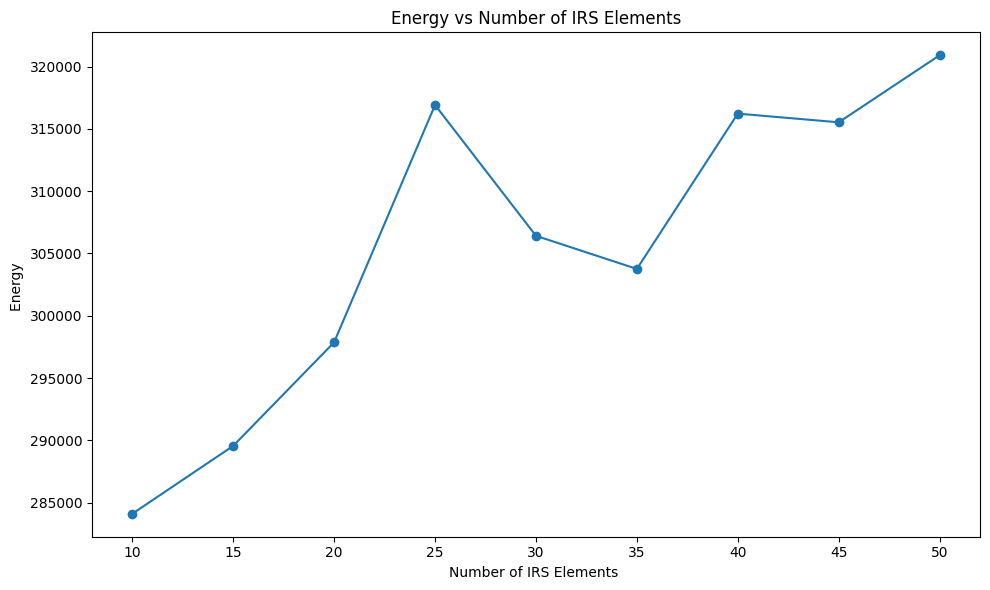

In [11]:
# Plotting graph for Sum of Fitness vs num_irs_ele
irs_element_values =range(10, 51, 5)
plt.figure(figsize=(10, 6))
plt.plot(irs_element_values, fitness_sums_GA, marker='o', linestyle='-')
plt.xlabel('Number of IRS Elements ')
plt.ylabel('Energy ')
plt.title('Energy vs Number of IRS Elements')
plt.xticks(irs_element_values)
plt.tight_layout()
plt.show()

In [12]:
num_population=50
num_bs = 5
num_generation = 1
num_uav_irs = 8
population_size = 50

numerical_keys_for_hc = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','f_km_value',
]

fitness_sums_HC = [] # Store sum of fitness values for each num_irs_ele
irs_element_values = range(10, 51, 5) # num_irs_ele values from 10 to 50 in steps of 5


for num_irs_ele in irs_element_values: # Loop through different num_irs_ele values
    print(f"Calculation for num_irs_ele: {num_irs_ele}")

    Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
    h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
    h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

    Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
    g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
    g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

    Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
    f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
    f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename


    all_best_combinations = []
    all_best_individuals = []

    for l in range(num_bs):
        all_best_individuals_bs = []
        P_m_har_value = P_m_har.values[l]
        T_m_har_value = T_m_har.values[l]
        P_m_down_value = P_m_down.values[l]

        index_list = list(range(500))
        random.shuffle(index_list)
        unique_row_indices = index_list[:population_size]

        h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :num_irs_ele].reset_index(drop=True) # Sliced columns
        f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
        valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
        P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


        for k in range(num_uav_irs):
            best_fitness = float('inf')
            best_individual = {}
            population = []
            V_lm_vfly_value = V_lm_vfly.values[k]
            V_lm_hfly_value = V_lm_hfly.values[k]
            D_l_hfly_value = D_l_hfly
            Wl_value = Wl
            Sub_value=0

            for i in range(len(valid_indices)):
                # Slice the Angle_UP_df, g_l_m_df, g_l_km_df_bs to num_irs_ele columns
                Angle_UP_df_sliced = Angle_UP_df.iloc[i, :num_irs_ele]
                g_l_m_df_sliced = g_l_m_df.iloc[k, :num_irs_ele]
                g_l_km_df_bs_sliced = g_l_km_df_bs.iloc[i, :num_irs_ele]

                h_il_up_value=h_kml_down(Angle_UP_df_sliced, g_l_m_df_sliced, g_l_km_df_bs_sliced, num_irs_ele) # Pass num_irs_ele
                Sub_value+=sub(P_km_up_bs[i],h_il_up_value)


            initial_solution_data = {}
            i=0 # Using first index for initialization
            f_km_value = f_km_bs[i] # Use BS-specific f_km
            P_km_up_value = P_km_up_bs[i] # Use BS-specific P_km_up

            Angle_row = Angle_df.iloc[i, :] # Use BS-specific Angle_df
            h_l_m_row = h_l_m_df.iloc[k, :] # Use BS-specific h_l_m_df
            h_l_km_row = h_l_km_df_bs.iloc[i, :] # Use BS-specific h_l_km_df
            Angle1_row = Angle_UP_df.iloc[i, :] # Use BS-specific Angle_UP_df
            g_l_m_row = g_l_m_df.iloc[k, :] # Use BS-specific g_l_m_df
            g_l_km_row = g_l_km_df_bs.iloc[i, :] # Use BS-specific g_l_km_df
            Angle2_row = Angle_har_df.iloc[i, :] # Use BS-specific Angle_har_df
            f_l_m_row = f_l_m_df.iloc[k, :] # Use BS-specific f_l_m_df
            f_l_km_row = f_l_km_df_bs.iloc[i, :] # Use BS-specific f_l_km_df


            # Calculate Bh and p_l_b


            # Calculate power values
            P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
            P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
            P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

            # Calculate time and energy values
            T_l_vfly_value = H_value / V_lm_vfly_value
            T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
            E_ml_har_value = P_m_har_value * T_m_har_value
            h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row,num_irs_ele) # Pass Series
            h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
            R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
            T_ml_down_value=D_m_current/R_ml_down_value
            E_ml_down_value = P_m_down_value * T_ml_down_value
            T_km_com_value = D_km / f_km_value
            h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row,num_irs_ele) # Pass Series, using same function, might need different one if logic is different

            R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
            T_km_up_value=D_m_current/R_kml_up_value # equation number 5
            T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
            P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
            P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
            P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
            E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

            # Calculate fitness for initial solution
            initial_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

            current_solution = {
                'fitness': initial_fitness,
                'data': {
                    'P_m_down_value': P_m_down_value,
                    'P_m_har_value': P_m_har_value,
                    'T_m_har_value': T_m_har_value,
                    'f_km_value': f_km_value,
                    'T_km_up_value': T_km_up_value,
                    'V_lm_vfly_value': V_lm_vfly_value,
                    'V_lm_hfly_value': V_lm_hfly_value,
                    'P_km_up_value':P_km_up_value,
                    'Angle1_row':Angle1_row.iloc[:num_irs_ele].copy(), # Sliced Series here
                    'Angle_row':Angle_row.iloc[:num_irs_ele].copy(), # Sliced Series here
                    'Angle2_row': Angle2_row.iloc[:num_irs_ele].copy(), # Sliced Series here
                }
            }
            best_individual = current_solution
            best_fitness = initial_fitness


            generations_data = []
            for j in range(num_generation): # Hill Climbing iterations
                # Generate neighbor solution by perturbing the current solution
                neighbor_solution_data = current_solution['data'].copy()
                for key in numerical_keys_for_hc:
                    neighbor_solution_data[key] += random.normal(loc=0, scale=1, size=(1))[0] # Reduced scale for smaller perturbations in HC


                # Compute neighbor fitness
                def compute_fitness(data):
                    P_m_down_value = data['P_m_down_value']
                    P_m_har_value = data['P_m_har_value']
                    T_m_har_value = data['T_m_har_value']
                    f_km_value = data['f_km_value']
                    T_km_up_value = data['T_km_up_value']
                    V_lm_vfly_value = data['V_lm_vfly_value']
                    V_lm_hfly_value = data['V_lm_hfly_value']
                    P_km_up_value=data['P_km_up_value']
                    Angle_row = data['Angle_row'] # Retrieve angle row from neighbor data
                    Angle1_row = data['Angle1_row'] # Retrieve angle row from neighbor data
                    Angle2_row = data['Angle2_row'] # Retrieve angle row from neighbor data


                    # Calculate Bh and p_l_b for neighbor
                    Bh = (1 - 2.2558 * pow(10, 4) * H_value)
                    Bh = max(1, Bh)
                    p_l_b = (delta / 8) * Bh * Ar * s * pow(V_tip, 3)

                    # Calculate power values
                    P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                    P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                    P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                    # Calculate time and energy values
                    T_l_vfly_value = H_value / V_lm_vfly_value
                    T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                    E_ml_har_value = P_m_har_value * T_m_har_value # Corrected:

                    h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row,num_irs_ele) # Using original Angle_row, h_l_m_row, h_l_km_row for neighbor as well - might need to be based on neighbor data if angles are also part of optimization
                    h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                    R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                    if R_ml_down_value <= 0: # check if R_ml_down_value is zero or negative
                        R_ml_down_value = 1e-9 # Assign a small positive value to avoid division by zero
                    T_ml_down_value=D_m_current/R_ml_down_value
                    E_ml_down_value = P_m_down_value * T_ml_down_value
                    T_km_com_value = D_km / f_km_value
                    T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                    P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                    P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                    P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                    E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                    h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row,num_irs_ele) # Corrected index to Angle2_row
                    E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected function call for E_kml_har
                    E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                    E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)


                    # Calculate fitness
                    fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                    current_data = {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'T_km_up_value': T_km_up_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row, # Carry forward original index
                                                                            }
                    if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                        return fitness_value, current_data
                    else:
                        return  float('inf'),{} # Return empty dict instead of float('inf') for data


                neighbor_fitness, neighbor_data1 = compute_fitness(neighbor_solution_data)


                # Decide whether to accept the neighbor
                if neighbor_fitness < current_solution['fitness']:
                    current_solution = {'fitness': neighbor_fitness, 'data': neighbor_data1}


                generations_data.append(current_solution.copy())
                # print(population[0])

            best_individual_pair = current_solution.copy()
            best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
            best_individual_pair['type'] = 'GA'
            best_individual_pair['bs_index'] = l
            best_individual_pair['uav_index'] = k
            all_best_individuals_bs.append(best_individual_pair)

            all_best_combinations.append({
                'bs_index': l,
                'uav_index': k,
                'best_fitness': current_solution['fitness'],
                'best_individual': best_individual_pair,
                'generation_fitness': [gen['fitness'] for gen in generations_data],
                'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
            })
            # print(f"Best Fitness for BS {l}, UAV {k}: {population[0]['fitness']:.4f}")

        # Find best individual for current BS across all UAVs
        best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
        # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


    # Select the best unique Base station and UAV-IRS pair using Auction based method
    combination_lookup = {}
    for combination in all_best_combinations:
        if combination['bs_index'] not in combination_lookup:
            combination_lookup[combination['bs_index']] = {}
        combination_lookup[combination['bs_index']][combination['uav_index']] = combination

    # Auction-based assignment
    best_assignments = []
    unassigned_bs = list(range(num_bs))
    unassigned_uavs = list(range(num_uav_irs))

    while unassigned_bs and unassigned_uavs:
        best_combination_overall = None

        for l in unassigned_bs:
            best_fitness_for_bs = float('inf')
            best_combination_for_bs = None
            for k in unassigned_uavs:
                if l in combination_lookup and k in combination_lookup[l]:
                    combination = combination_lookup[l][k]
                    if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                        best_fitness_for_bs = combination['best_fitness']
                        best_combination_for_bs = combination

            if best_combination_for_bs:
                if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                    best_combination_overall = best_combination_for_bs

        if best_combination_overall:
            best_assignments.append(best_combination_overall)
            unassigned_bs.remove(best_combination_overall['bs_index'])
            unassigned_uavs.remove(best_combination_overall['uav_index'])

    # Print and Plotting
    print(f"\n--- Best Unique UAV Assignments (Auction Based Method) ---")
    best_pair_for_plot = None
    min_fitness_for_plot = float('inf')

    sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
    for assignment in best_assignments:
        print(f"\nBest Assignment for BS {assignment['bs_index']}:")
        print(f" UAV Index: {assignment['uav_index']}")
        best_ind = assignment['best_individual']
        print(f" Best Individual:")
        print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
        print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
        unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
        for key, value in best_ind['data'].items():
            if isinstance(value, pd.Series):
                print(f"  {key}: Series: \n{value}") # Print the entire Series directly - corrected line
            elif isinstance(value, list): # Handle list type values explicitly
                print(f"  {key}: {value}") # print list directly without formatting
            else:
                print(f"  {key}: {value:.4f}") # Format scalar values

        print("-" * 20)
        sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

        if assignment['best_individual']['fitness'] < min_fitness_for_plot:
            min_fitness_for_plot = assignment['best_individual']['fitness']
            best_pair_for_plot = assignment

    fitness_sums_HC.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

    # Unassigned BS/UAVs
    if unassigned_bs:
        print("\n--- Base Stations without Assigned UAVs ---")
        for bs_index in unassigned_bs:
            print(f"  BS {bs_index} : No UAV is assigned")
            print("-" * 20)

    if unassigned_uavs:
        print("\n--- UAVs without Assigned Base Stations ---")
        for uav_index in unassigned_uavs:
            print(f"  UAV {uav_index} : No BS is assigned")
            print("-" * 20)

Calculation for num_irs_ele: 10

--- Best Unique UAV Assignments (Auction Based Method) ---

Best Assignment for BS 2:
 UAV Index: 3
 Best Individual:
  Generation: 1, Type: GA
  Fitness: 54750.9015
  P_m_down_value: 2.5208
  P_m_har_value: 1.6467
  T_m_har_value: 2.0120
  f_km_value: 3.5347
  T_km_up_value: 0.8424
  V_lm_vfly_value: 65.6336
  V_lm_hfly_value: 66.7540
  P_km_up_value: 7.0777
  Angle1_row: Series: 
0     23.094594
1      5.875864
2     33.462215
3    113.455504
4    141.308037
5     88.359471
6    156.697950
7    107.600529
8     67.455781
9     59.842569
Name: 0, dtype: float64
  Angle_row: Series: 
0    109.636284
1     32.019189
2    133.727994
3    178.387272
4     71.930267
5    167.406641
6     84.470200
7     39.691029
8      9.299199
9      9.438781
Name: 0, dtype: float64
  Angle2_row: Series: 
0     11.752947
1     84.771303
2     77.449059
3    176.780151
4    146.369943
5    147.888861
6    113.170820
7    149.949867
8     41.271809
9    135.585468
Name: 0, 

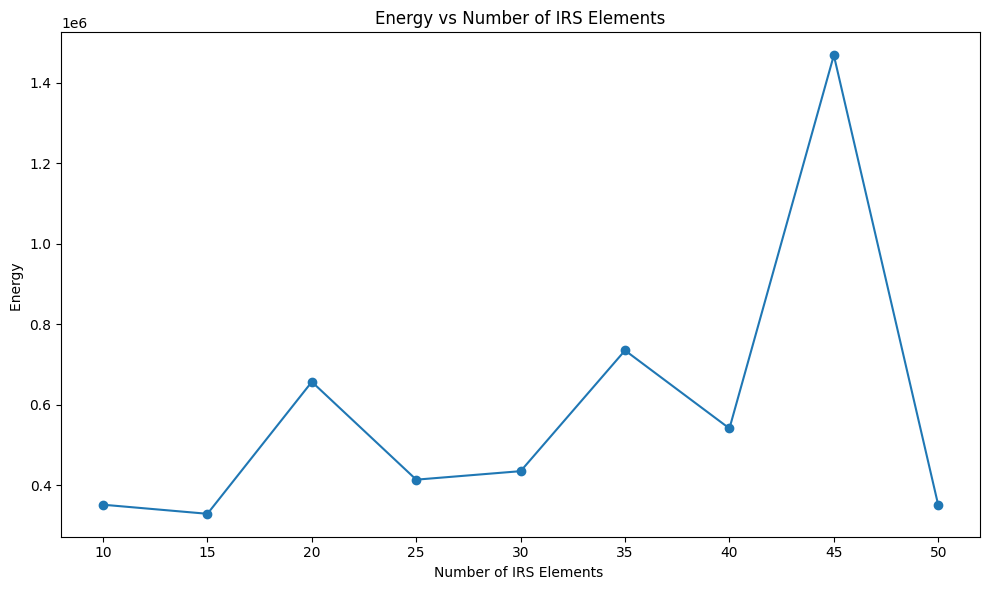

In [ ]:
# Plotting graph for Sum of Fitness vs num_irs_ele
irs_element_values =range(10, 51, 5)
plt.figure(figsize=(10, 6))
plt.rcParams["font.size"] = "20"
plt.plot(irs_element_values, fitness_sums_HC, marker='o', linestyle='-')
plt.xlabel('Number of IRS Elements ',size=22)
plt.ylabel('Energy ',size=22)
plt.title('Energy vs Number of IRS Elements',size=22)
plt.xticks(irs_element_values)
plt.tight_layout()
plt.show()

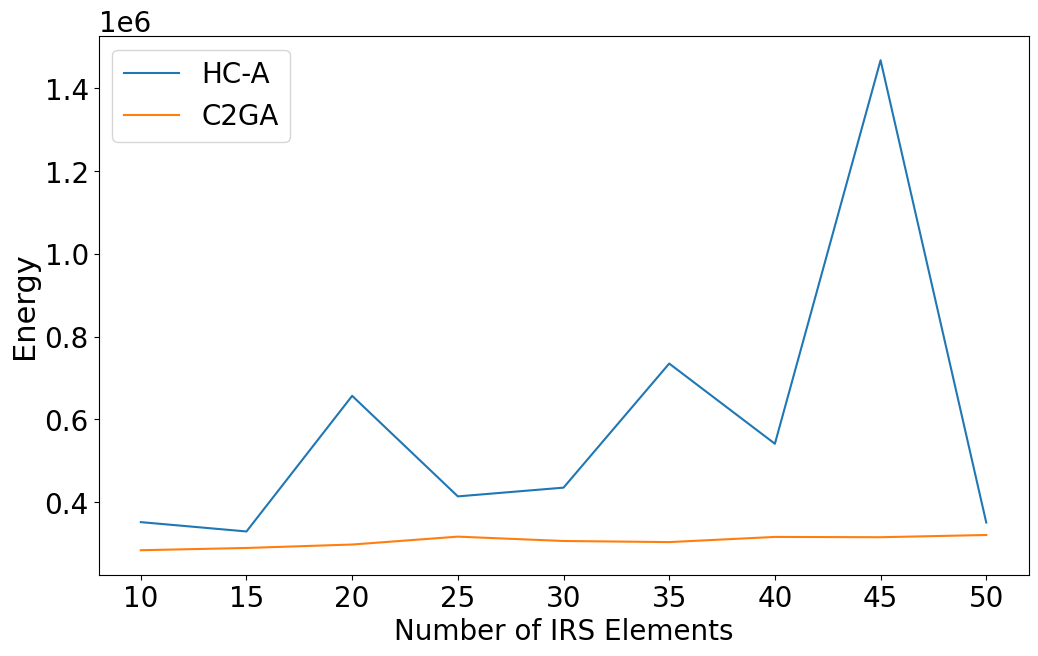

In [ ]:
plt.figure(figsize=(12, 7))
num_irs =range(10, 51, 5)

plt.rcParams["font.size"] = "20"
plt.plot(num_irs, fitness_sums_HC, label = "HC-A")
plt.plot(num_irs, fitness_sums_GA, label = "C2GA")
plt.xlabel('Number of IRS Elements',size=20)
plt.ylabel('Energy',size=22)
plt.legend()
plt.savefig("Energy vs IRS .pdf", format="pdf", bbox_inches="tight", dpi=800)
plt.show()

In [16]:
percentage_improvements = []
better_algorithm_counts = {'HC-A': 0, 'C2GA': 0, 'Tie': 0}
average_percentage_improvement_HC_A = 0
average_percentage_improvement_C2GA = 0

print("\n--- Algorithm Comparison ---")
for i in range(len(num_irs)):
    hc_a_fitness = fitness_sums_HC[i]
    c2ga_fitness = fitness_sums_GA[i]
    data_size = num_irs[i]

    if hc_a_fitness < c2ga_fitness:
        better_fitness = hc_a_fitness
        worse_fitness = c2ga_fitness
        better_algorithm = "HC-A"
        worse_algorithm = "C2GA"
        better_algorithm_counts['HC-A'] += 1
    elif c2ga_fitness < hc_a_fitness:
        better_fitness = c2ga_fitness
        worse_fitness = hc_a_fitness
        better_algorithm = "C2GA"
        worse_algorithm = "HC-A"
        better_algorithm_counts['C2GA'] += 1
    else:
        better_algorithm = "Tie"
        better_algorithm_counts['Tie'] += 1
        percentage_improvement = 0 # No improvement if it's a tie
        percentage_improvements.append(percentage_improvement) # Append 0 for tie
        print(f"Data size {data_size:.1f}: Tie in Energy ({hc_a_fitness:.2f} vs {c2ga_fitness:.2f}) - 0.00% Improvement")
        continue # Skip percentage calculation for tie

    percentage_improvement = ((worse_fitness - better_fitness) / worse_fitness) * 100
    percentage_improvements.append(percentage_improvement)

    print(f"Data size {data_size:.1f}: {better_algorithm} is better by {percentage_improvement:.2f}% (Energy: {better_fitness:.2f} vs {worse_fitness:.2f})")


# Calculate average percentage improvement for cases where HC-A is better
hc_a_improvements = [p for i, p in enumerate(percentage_improvements) if fitness_sums_HC[i] < fitness_sums_GA[i]]
if hc_a_improvements:
    average_percentage_improvement_HC_A = np.mean(hc_a_improvements)

# Calculate average percentage improvement for cases where C2GA is better
c2ga_improvements = [p for i, p in enumerate(percentage_improvements) if fitness_sums_GA[i] < fitness_sums_HC[i]]
if c2ga_improvements:
    average_percentage_improvement_C2GA = np.mean(c2ga_improvements)


print("\n--- Summary ---")
print("Algorithm Performance Comparison:")
print(f"  HC-A was better in {better_algorithm_counts['HC-A']} out of {len(num_irs)} cases.")
print(f"  C2GA was better in {better_algorithm_counts['C2GA']} out of {len(num_irs)} cases.")
print(f"  Tie in {better_algorithm_counts['Tie']} out of {len(num_irs)} cases.")

if better_algorithm_counts['HC-A'] > better_algorithm_counts['C2GA']:
    if hc_a_improvements:
        print(f"\nOverall, HC-A (Hill Climbing) is generally better.")
        print(f"On average, when HC-A is better, it reduces energy consumption by approximately {average_percentage_improvement_HC_A:.2f}%.")

elif better_algorithm_counts['C2GA'] > better_algorithm_counts['HC-A']:
    if c2ga_improvements:
        print(f"\nOverall, C2GA (Genetic Algorithm) is generally better.")
        print(f"On average, when C2GA is better, it reduces energy consumption by approximately {average_percentage_improvement_C2GA:.2f}%.")
else:
    print("\nOverall, both algorithms perform similarly on average based on the number of better cases.")





--- Algorithm Comparison ---
Data size 10.0: C2GA is better by 19.28% (Energy: 284111.83 vs 351980.52)
Data size 15.0: C2GA is better by 12.10% (Energy: 289560.93 vs 329427.72)
Data size 20.0: C2GA is better by 54.67% (Energy: 297870.27 vs 657078.75)
Data size 25.0: C2GA is better by 23.48% (Energy: 316911.51 vs 414178.43)
Data size 30.0: C2GA is better by 29.61% (Energy: 306415.48 vs 435296.37)
Data size 35.0: C2GA is better by 58.68% (Energy: 303759.02 vs 735075.98)
Data size 40.0: C2GA is better by 41.58% (Energy: 316220.07 vs 541324.38)
Data size 45.0: C2GA is better by 78.51% (Energy: 315522.99 vs 1467909.66)
Data size 50.0: C2GA is better by 8.56% (Energy: 320902.46 vs 350940.41)

--- Summary ---
Algorithm Performance Comparison:
  HC-A was better in 0 out of 9 cases.
  C2GA was better in 9 out of 9 cases.
  Tie in 0 out of 9 cases.

Overall, C2GA (Genetic Algorithm) is generally better.
On average, when C2GA is better, it reduces energy consumption by approximately 36.27%.
